Quantitative Economics with Python

Thomas J. Sargent John Stachurski


## Overview

Linear regression is a standard tool for analyzing the relationship between two or more variables.

In this lecture, we’ll use the Python package `statsmodels` to estimate, interpret, and visualize linear regression models.

Along the way, we’ll discuss a variety of topics, including

- simple and multivariate linear regression  
- visualization  
- endogeneity and omitted variable bias  
- two-stage least squares  


As an example, we will replicate results from Acemoglu, Johnson and Robinson’s seminal paper [[AJR01]](https://python-programming.quantecon.org/zreferences.html#acemoglu2001).

- A copy of the paper can be downloaded [here](https://economics.mit.edu/files/4123).  


In the paper, the authors emphasize the importance of institutions in economic development.

The main contribution is the use of settler mortality rates as a source of *exogenous* variation in institutional differences.


# Linear Regression in Python

In [1]:
!pip install linearmodels

     |████████████████████████████████| 1.5MB 2.8MB/s 


In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import statsmodels.api as sm
from statsmodels.iolib.summary2 import summary_col
from linearmodels.iv import IV2SLS

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
df1 = pd.read_stata('https://github.com/QuantEcon/lecture-python/blob/master/source/_static/lecture_specific/ols/maketable1.dta?raw=true')
df1.head()

,shortnam,euro1900,excolony,avexpr,logpgp95,cons1,cons90,democ00a,cons00a,extmort4,logem4,loghjypl,baseco
0,AFG,0.000000,1.0,NaN,NaN,1.0,2.0,1.0,1.0,93.699997,4.540098,NaN,NaN
1,AGO,8.000000,1.0,5.363636,7.770645,3.0,3.0,0.0,1.0,280.000000,5.634789,-3.411248,1.0
2,ARE,0.000000,1.0,7.181818,9.804219,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ARG,60.000004,1.0,6.386364,9.133459,1.0,6.0,3.0,3.0,68.900002,4.232656,-0.872274,1.0
4,ARM,0.000000,0.0,NaN,7.682482,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


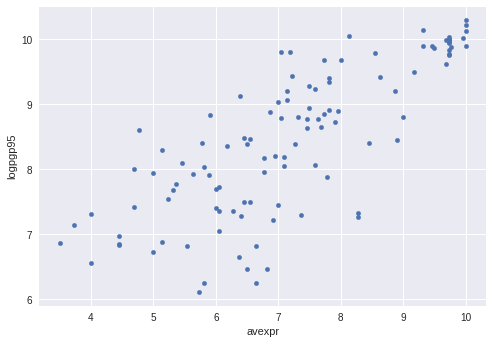

In [4]:
plt.style.use('seaborn')

df1.plot(x='avexpr', y='logpgp95', kind='scatter')
plt.show()

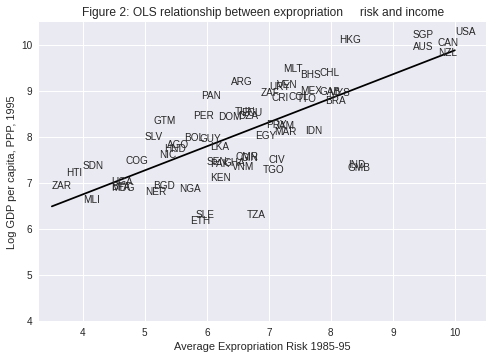

In [5]:
# Dropping NA's is required to use numpy's polyfit
df1_subset = df1.dropna(subset=['logpgp95', 'avexpr'])

# Use only 'base sample' for plotting purposes
df1_subset = df1_subset[df1_subset['baseco'] == 1]

X = df1_subset['avexpr']
y = df1_subset['logpgp95']
labels = df1_subset['shortnam']

# Replace markers with country labels
fig, ax = plt.subplots()
ax.scatter(X, y, marker='')

for i, label in enumerate(labels):
    ax.annotate(label, (X.iloc[i], y.iloc[i]))

# Fit a linear trend line
ax.plot(np.unique(X),
         np.poly1d(np.polyfit(X, y, 1))(np.unique(X)),
         color='black')

ax.set_xlim([3.3,10.5])
ax.set_ylim([4,10.5])
ax.set_xlabel('Average Expropriation Risk 1985-95')
ax.set_ylabel('Log GDP per capita, PPP, 1995')
ax.set_title('Figure 2: OLS relationship between expropriation \
    risk and income')
plt.show()

In [6]:
df1['const'] = 1

In [7]:
reg1 = sm.OLS(endog=df1['logpgp95'], exog=df1[['const', 'avexpr']], \
    missing='drop')
type(reg1)

statsmodels.regression.linear_model.OLS

In [8]:
results = reg1.fit()
type(results)

statsmodels.regression.linear_model.RegressionResultsWrapper

In [9]:
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:               logpgp95   R-squared:                       0.611
Model:                            OLS   Adj. R-squared:                  0.608
Method:                 Least Squares   F-statistic:                     171.4
Date:                Sat, 20 Jun 2020   Prob (F-statistic):           4.16e-24
Time:                        06:34:55   Log-Likelihood:                -119.71
No. Observations:                 111   AIC:                             243.4
Df Residuals:                     109   BIC:                             248.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.6261      0.301     15.391      0.0

In [10]:
mean_expr = np.mean(df1_subset['avexpr'])
mean_expr

6.515625

In [11]:
predicted_logpdp95 = 4.63 + 0.53 * 7.07
predicted_logpdp95

8.3771

In [12]:
results.predict(exog=[1, mean_expr])

array([8.09156367])

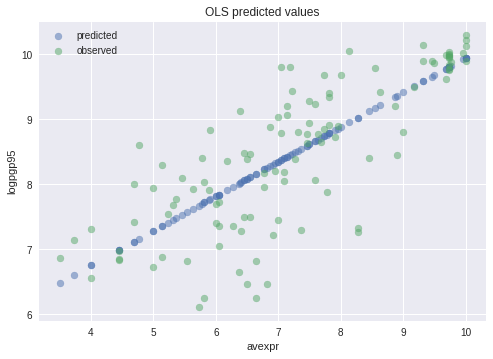

In [13]:
# Drop missing observations from whole sample

df1_plot = df1.dropna(subset=['logpgp95', 'avexpr'])

# Plot predicted values

fix, ax = plt.subplots()
ax.scatter(df1_plot['avexpr'], results.predict(), alpha=0.5,
        label='predicted')

# Plot observed values

ax.scatter(df1_plot['avexpr'], df1_plot['logpgp95'], alpha=0.5,
        label='observed')

ax.legend()
ax.set_title('OLS predicted values')
ax.set_xlabel('avexpr')
ax.set_ylabel('logpgp95')
plt.show()

In [14]:
df2 = pd.read_stata('https://github.com/QuantEcon/lecture-python/blob/master/source/_static/lecture_specific/ols/maketable2.dta?raw=true')

# Add constant term to dataset
df2['const'] = 1

# Create lists of variables to be used in each regression
X1 = ['const', 'avexpr']
X2 = ['const', 'avexpr', 'lat_abst']
X3 = ['const', 'avexpr', 'lat_abst', 'asia', 'africa', 'other']

# Estimate an OLS regression for each set of variables
reg1 = sm.OLS(df2['logpgp95'], df2[X1], missing='drop').fit()
reg2 = sm.OLS(df2['logpgp95'], df2[X2], missing='drop').fit()
reg3 = sm.OLS(df2['logpgp95'], df2[X3], missing='drop').fit()

In [15]:
info_dict={'R-squared' : lambda x: f"{x.rsquared:.2f}",
           'No. observations' : lambda x: f"{int(x.nobs):d}"}

results_table = summary_col(results=[reg1,reg2,reg3],
                            float_format='%0.2f',
                            stars = True,
                            model_names=['Model 1',
                                         'Model 3',
                                         'Model 4'],
                            info_dict=info_dict,
                            regressor_order=['const',
                                             'avexpr',
                                             'lat_abst',
                                             'asia',
                                             'africa'])

results_table.add_title('Table 2 - OLS Regressions')

print(results_table)

        Table 2 - OLS Regressions
                 Model 1 Model 3 Model 4 
-----------------------------------------
const            4.63*** 4.87*** 5.85*** 
                 (0.30)  (0.33)  (0.34)  
avexpr           0.53*** 0.46*** 0.39*** 
                 (0.04)  (0.06)  (0.05)  
lat_abst                 0.87*   0.33    
                         (0.49)  (0.45)  
asia                             -0.15   
                                 (0.15)  
africa                           -0.92***
                                 (0.17)  
other                            0.30    
                                 (0.37)  
R-squared        0.61    0.62    0.72    
No. observations 111     111     111     
Standard errors in parentheses.
* p<.1, ** p<.05, ***p<.01


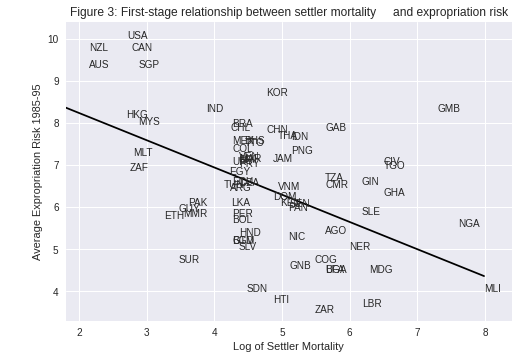

In [16]:
# Dropping NA's is required to use numpy's polyfit
df1_subset2 = df1.dropna(subset=['logem4', 'avexpr'])

X = df1_subset2['logem4']
y = df1_subset2['avexpr']
labels = df1_subset2['shortnam']

# Replace markers with country labels
fig, ax = plt.subplots()
ax.scatter(X, y, marker='')

for i, label in enumerate(labels):
    ax.annotate(label, (X.iloc[i], y.iloc[i]))

# Fit a linear trend line
ax.plot(np.unique(X),
         np.poly1d(np.polyfit(X, y, 1))(np.unique(X)),
         color='black')

ax.set_xlim([1.8,8.4])
ax.set_ylim([3.3,10.4])
ax.set_xlabel('Log of Settler Mortality')
ax.set_ylabel('Average Expropriation Risk 1985-95')
ax.set_title('Figure 3: First-stage relationship between settler mortality \
    and expropriation risk')
plt.show()

In [17]:
# Import and select the data
df4 = pd.read_stata('https://github.com/QuantEcon/lecture-python/blob/master/source/_static/lecture_specific/ols/maketable4.dta?raw=true')
df4 = df4[df4['baseco'] == 1]

# Add a constant variable
df4['const'] = 1

# Fit the first stage regression and print summary
results_fs = sm.OLS(df4['avexpr'],
                    df4[['const', 'logem4']],
                    missing='drop').fit()
print(results_fs.summary())

                            OLS Regression Results                            
Dep. Variable:                 avexpr   R-squared:                       0.270
Model:                            OLS   Adj. R-squared:                  0.258
Method:                 Least Squares   F-statistic:                     22.95
Date:                Sat, 20 Jun 2020   Prob (F-statistic):           1.08e-05
Time:                        06:36:52   Log-Likelihood:                -104.83
No. Observations:                  64   AIC:                             213.7
Df Residuals:                      62   BIC:                             218.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          9.3414      0.611     15.296      0.0

In [18]:
df4['predicted_avexpr'] = results_fs.predict()

results_ss = sm.OLS(df4['logpgp95'],
                    df4[['const', 'predicted_avexpr']]).fit()
print(results_ss.summary())

                            OLS Regression Results                            
Dep. Variable:               logpgp95   R-squared:                       0.477
Model:                            OLS   Adj. R-squared:                  0.469
Method:                 Least Squares   F-statistic:                     56.60
Date:                Sat, 20 Jun 2020   Prob (F-statistic):           2.66e-10
Time:                        06:37:05   Log-Likelihood:                -72.268
No. Observations:                  64   AIC:                             148.5
Df Residuals:                      62   BIC:                             152.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                1.9097      0.823  

In [19]:
iv = IV2SLS(dependent=df4['logpgp95'],
            exog=df4['const'],
            endog=df4['avexpr'],
            instruments=df4['logem4']).fit(cov_type='unadjusted')

print(iv.summary)

                          IV-2SLS Estimation Summary                          
Dep. Variable:               logpgp95   R-squared:                      0.1870
Estimator:                    IV-2SLS   Adj. R-squared:                 0.1739
No. Observations:                  64   F-statistic:                    37.568
Date:                Sat, Jun 20 2020   P-value (F-stat)                0.0000
Time:                        06:37:14   Distribution:                  chi2(1)
Cov. Estimator:            unadjusted                                         
                                                                              
                             Parameter Estimates                              
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
const          1.9097     1.0106     1.8897     0.0588     -0.0710      3.8903
avexpr         0.9443     0.1541     6.1293     0.00

### Exercise 1

In the lecture, we think the original model suffers from endogeneity
bias due to the likely effect income has on institutional development.

Although endogeneity is often best identified by thinking about the data
and model, we can formally test for endogeneity using the **Hausman
test**.

We want to test for correlation between the endogenous variable,
$ avexpr_i $, and the errors, $ u_i $

$$
\begin{aligned}
 H_0 : Cov(avexpr_i, u_i) = 0  \quad (no\ endogeneity) \\
 H_1 : Cov(avexpr_i, u_i) \neq 0 \quad (endogeneity)
 \end{aligned}
$$

This test is running in two stages.

First, we regress $ avexpr_i $ on the instrument, $ logem4_i $

$$
avexpr_i = \pi_0 + \pi_1 logem4_i + \upsilon_i
$$

Second, we retrieve the residuals $ \hat{\upsilon}_i $ and include
them in the original equation

$$
logpgp95_i = \beta_0 + \beta_1 avexpr_i + \alpha \hat{\upsilon}_i + u_i
$$

If $ \alpha $ is statistically significant (with a p-value < 0.05),
then we reject the null hypothesis and conclude that $ avexpr_i $ is
endogenous.

Using the above information, estimate a Hausman test and interpret your
results.

In [20]:
# Load in data
df4 = pd.read_stata('https://github.com/QuantEcon/lecture-python/blob/master/source/_static/lecture_specific/ols/maketable4.dta?raw=true')

# Add a constant term
df4['const'] = 1

# Estimate the first stage regression
reg1 = sm.OLS(endog=df4['avexpr'],
              exog=df4[['const', 'logem4']],
              missing='drop').fit()

# Retrieve the residuals
df4['resid'] = reg1.resid

# Estimate the second stage residuals
reg2 = sm.OLS(endog=df4['logpgp95'],
              exog=df4[['const', 'avexpr', 'resid']],
              missing='drop').fit()

print(reg2.summary())

                            OLS Regression Results                            
Dep. Variable:               logpgp95   R-squared:                       0.689
Model:                            OLS   Adj. R-squared:                  0.679
Method:                 Least Squares   F-statistic:                     74.05
Date:                Sat, 20 Jun 2020   Prob (F-statistic):           1.07e-17
Time:                        06:38:36   Log-Likelihood:                -62.031
No. Observations:                  70   AIC:                             130.1
Df Residuals:                      67   BIC:                             136.8
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.4782      0.547      4.530      0.0

### Exercise 2

The OLS parameter $ \beta $ can also be estimated using matrix
algebra and `numpy` (you may need to review the
[numpy](https://python-programming.quantecon.org/numpy.html) lecture to
complete this exercise).

The linear equation we want to estimate is (written in matrix form)

$$
y = X\beta + u
$$

To solve for the unknown parameter $ \beta $, we want to minimize
the sum of squared residuals

$$
\underset{\hat{\beta}}{\min} \hat{u}'\hat{u}
$$

Rearranging the first equation and substituting into the second
equation, we can write

$$
\underset{\hat{\beta}}{\min} \ (Y - X\hat{\beta})' (Y - X\hat{\beta})
$$

Solving this optimization problem gives the solution for the
$ \hat{\beta} $ coefficients

$$
\hat{\beta} = (X'X)^{-1}X'y
$$

Using the above information, compute $ \hat{\beta} $ from model 1
using `numpy` - your results should be the same as those in the
`statsmodels` output from earlier in the lecture.

In [21]:
# Load in data
df1 = pd.read_stata('https://github.com/QuantEcon/lecture-python/blob/master/source/_static/lecture_specific/ols/maketable1.dta?raw=true')
df1 = df1.dropna(subset=['logpgp95', 'avexpr'])

# Add a constant term
df1['const'] = 1

# Define the X and y variables
y = np.asarray(df1['logpgp95'])
X = np.asarray(df1[['const', 'avexpr']])

# Compute β_hat
β_hat = np.linalg.solve(X.T @ X, X.T @ y)

# Print out the results from the 2 x 1 vector β_hat
print(f'β_0 = {β_hat[0]:.2}')
print(f'β_1 = {β_hat[1]:.2}')

β_0 = 4.6
β_1 = 0.53
